# Objective corals age model determination

*This method was tested with Pacific corals. Results are avalaible in following article:*
***Dassie et al 2016, in prep.***

**Methodology**

The aim of the method is to determine an objective coral d18O time series age model. This method is called "Objective" and is compared to the original age model method determined manually using Arand Sea Ager/Timer softwares ("Timer" method). 
The "Objective" method is based on determining objectively the number of d18O seasonal cycles.
First step is to find the total number of coral d18O cycles : succession of a maximun and minimum d18O values corresponding to seasonal temperature minimum and maximun, respectively. The top age of the d18O time series being known (coral being alive at time of collection) we then assigned dates to the coral d18O min/max. The last step was to interpolate d18O vlaues in order to obtain monthy values - 6 values between two conscutive max/min.
Time differences between the two methods are labelled deltaM and are in months.

**Detection algorithm steps:**
- init (initialisation) : find first extremum and determine its type (min or max)
- detection: find all extremums in dO18, split them in min/max
- checking: check that there is only one max between two min and vice-versa. If there are severals keep the highest/lowest.
- remove non significant data: check that min/max distance > precision (given param). 
    - If this not the case, check that next min/max is not too far (max nb steps is given).
        - If next min/max is too far, keep min/max
        - Else keep the smallest/highest in the intervall (check to keep min/max alternation)

**Interpolation:**

We considerate that there is *1 year between 2 min (or max)*, thus 6 months between min/max.
1. Initialisate first date with sample date 
2. Rebuild from date sample to last extremum based on assumption above (first date known from the nearest min/max temperature cycle from the coral collection date)
3. compute distance between current min/max
4. interpolate the 6 dO18 values linearly using min/max distance
5. go to next extremum (min or max). And go to *step 3* until last extremum


### Code source license

**Coral_AgeModel source code**<br />
Copyright (C) 2016  Nicolas LEBAS<br />
nicolas.lebas@locean-ipsl.upmc.fr

*This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.*

*This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.*

*You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/gpl.txt> or
write to the Free Software Foundation, Inc.,
51 Franklin Street, Fifth Floor, Boston, MA 02110-1301  USA.*
<br />
<br />

## Fit to collected data

In [8]:
import pandas as pd
import numpy as np
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt

''' Parameters to spike detection '''
ts1yr = 7 # max time step nb for a full cycle (year)
midyr = 4 # half a cycle
mdist = 0.4 # mean min/max distance
stdist = 0.2 # std of min/max distance
pkrate = 1.3 # datermine min dist between 2 spikes = (pkrate*ts1yr)

''' Load coral data '''
df=pd.read_csv('coral.csv',sep=";")

In [9]:
''' Min/Max detection in DeltaO2 '''
ndat = len(df.dO18) # number of data
is_firstMin = False # if first extremum is a min ?
is_firstMax = False # if first extremum is a max ?
is_lastMin = False # if last extremum is a min ?
is_lastMax = False # if last extremum is a max ?
imax = []; imin = [] # all max & min index
fstpk = -1 # first extrem index
idCurMax = -1; idCurMin = -1 # last max & min index

### Find and categorize all extremums (Min and Max)
# keep most extremum in half a cycle if several and difference > precision
for i in range(1,(ndat-1)):
    if( (df.dO18[i-1] <= df.dO18[i]) and (df.dO18[i+1] < df.dO18[i]) ):
        if( idCurMax == -1 or (i-idCurMax) >= midyr ): # no max or last too far
            imax.append(i)
            idCurMax = i
        elif( df.dO18[i] > df.dO18[imax[-1]] ): # new max > last max
            imax[-1] = i
    elif( (df.dO18[i-1] >= df.dO18[i]) and (df.dO18[i+1] > df.dO18[i]) ):
        if( idCurMin == -1 or (i-idCurMin) >= midyr ): # no min or last too far
            imin.append(i)
            idCurMin = i
        elif( df.dO18[i] < df.dO18[imin[-1]] ): # new min < last min
            imin[-1] = i

### Keep only smallest min between two max
i=0; j=0; imin2=[]
while(j < len(imin) and i < len(imax)):
    inds = [ n for n in range(j, len(imin)) if imin[n]<imax[i] ]
    if(len(inds) < 1):
        i = i + 1
        if(i == len(imax)): # no more max
            curIdMin = j
            for jj in range(j+1, len(imin)):
                if( df.dO18[imin[jj]] < df.dO18[imin[curIdMin]] ):
                    curIdMin = jj # new min
            imin2.append(imin[curIdMin])
    elif(len(inds) == 1):
        imin2.append(imin[inds[0]])
    else: # if several min, keep the smallest
        curIdMin = inds[0]
        for jj in inds:
            if( df.dO18[imin[jj]] < df.dO18[imin[curIdMin]] ):
                curIdMin = jj
        imin2.append(imin[curIdMin])
    j = j + len(inds)

In [ ]:
### Keep only highest max between two min

i=0; j=0; imax2=[] 
while(j < len(imin2) and i < len(imax)):
    inds = [ n for n in range(i, len(imax)) if imax[n]<imin2[j] ]
    if(len(inds) < 1):
        j = j + 1
        if(j == len(imin2)): # no more min
            curIdMax = i
            for ii in range(i+1, len(imax)):
                if( df.dO18[imax[ii]] > df.dO18[imax[curIdMax]] ):
                    curIdMax = ii # new max
            imax2.append(imax[curIdMax])
    elif(len(inds) == 1):
        imax2.append(imax[inds[0]])
    else: # if several max, keep the highest
        curIdMax = inds[0]
        for ii in inds:
            if( df.dO18[imax[ii]] > df.dO18[imax[curIdMax]] ):
                curIdMax = ii # new max
        imax2.append(imax[curIdMax])
    i = i + len(inds)

### Find and determine the first extremum (Min or Max)
if(imin2[0] < imax2[0]):
    is_firstMin = True
    print("<<< First extremum is a min (i="+str(imin2[0])+") >>>")
    xtrem1 = imin2
    xtrem2 = imax2
elif(imin2[0] > imax2[0]):
    is_firstMax = True
    print("<<< First extremum is a max (i="+str(imax2[0])+") >>>")
    xtrem1 = imax2
    xtrem2 = imin2
else:
    error("No definition of the first extremum (not min and not max) !")

### Remove all Min and Max when dist(Max-Min) < min(dist-std)

# remove little local extremums
i=0; j=0; nskip=0
is_skipI = False
is_skipJ = False
ilast = 0 # last extrem1 index
jlast = -1 # last extrem2 index
new_xtrem1 = [xtrem1[i]]
new_xtrem2 = []


In [ ]:
while(i < len(xtrem1) and j < len(xtrem2)):
    if(not is_skipI):
        is_skipJ = False
        if( jlast > ilast ): # Can't keep 2 consecutive same extrem type
            j=j-1 # check i after next i
        elif((abs(df.dO18[xtrem1[ilast]]-df.dO18[xtrem2[j]]))>(mdist-stdist)):
            new_xtrem2.append(xtrem2[j])
            jlast=j
        elif((j+1)<len(xtrem2) and j>0 and (xtrem2[j+1]-xtrem2[jlast])>=pkrate*ts1yr):
            new_xtrem2.append(xtrem2[j])
            jlast=j
        else:
            if((i+1) < len(xtrem1)): # keep highest min/max
                if( is_firstMax and (df.dO18[xtrem1[i+1]]<df.dO18[xtrem1[ilast]]) or
                    is_firstMin and (df.dO18[xtrem1[i+1]]>df.dO18[xtrem1[ilast]])):
                    j = j + 1 # test next extrem2
                    is_skipJ = True # look for next without rereading other xtrem
                else:
                    if(xtrem1[i]-xtrem1[ilast-1] >= pkrate*ts1yr ):
                        new_xtrem2.append(xtrem2[j])
                        jlast=j
                    elif(ilast>-1):
                        new_xtrem1.pop() # remove previous if smaller
                        ilast=ilast-1
                        is_skipJ = False # look for next without reading other xtrem
            else:
                new_xtrem1.pop() # remove previous if smaller
                ilast=ilast-1
            nskip=nskip+1
        i = i + 1
        
        if(i == len(xtrem1) and (j+1) < len(xtrem2) ): # no more xtrem1 but xtrem2
            for x in range((j+1), len(xtrem2)): # compare dist to last xtrem1
                if((abs(df.dO18[xtrem1[ilast]]-df.dO18[xtrem2[x]]))>(mdist-stdist)):
                    new_xtrem2.append(xtrem2[j])
                    jlast = j
                    


In [ ]:
    if(not is_skipJ):
        is_skipI = False
        if(i < len(xtrem1)):
            if( ilast > jlast ): # Can't keep 2 consecutive extrem
                i=i-1 # check i after next j
            elif((abs(df.dO18[xtrem1[i]]-df.dO18[xtrem2[jlast]]))>(mdist-stdist)):
                new_xtrem1.append(xtrem1[i])
                ilast=i
            elif((i+1)<len(xtrem1) and i>0 and (xtrem1[i+1]-xtrem1[ilast])>=pkrate*ts1yr):
                new_xtrem1.append(xtrem1[i])
                ilast=i
            else:
                if((j+1) < len(xtrem2)): # keep highest min/max
                    if(is_firstMin and (df.dO18[xtrem2[j+1]]<df.dO18[xtrem2[jlast]]) or
                       is_firstMax and (df.dO18[xtrem2[j+1]]>df.dO18[xtrem2[jlast]])):
                        i = i + 1 # test next extrem1
                        is_skipI = True # look for next without reading other extremum
                    else:
                        if(xtrem2[j]-xtrem2[jlast-1] >= pkrate*ts1yr ):
                            new_xtrem1.append(xtrem1[i])
                            ilast=i
                        elif(jlast>-1):
                            new_xtrem2.pop() # remove previous if smaller
                            jlast=jlast-1
                            is_skipI = False # look for next
                else:
                    new_xtrem2.pop() # remove previous if smaller
                    jlast=jlast-1
                nskip=nskip+1
            j = j + 1
            
            if(j== len(xtrem2) and (i+1) < len(xtrem1)): # no more xtrem2 but xtrem1
                for x in range(i+1,len(xtrem1)): # compare dist to last xtrem2
                    if((abs(df.dO18[xtrem1[x]]-df.dO18[xtrem2[jlast]]))>(mdist-stdist)):
                        new_xtrem1.append(xtrem1[i])
                        ilast = i


                        
                        
                        
                        
if(jlast < ilast):
    if(is_firstMax):
        is_lastMax = True
    else:
        is_lastMin = True
else:
    if(is_firstMax):
        is_lastMin = True
    else:
        is_lastMax = True


 

        
print("NB Skipped spike: "+str(nskip))
print('End of detection (^_^)')

### Reconstructed Ages

In [ ]:
''' Load timer data '''
timer=pd.read_csv('timer.csv',sep=";")
''' Build age model '''
# Define sign of addition for dO18 interpolation
if(is_firstMax):
    sign = -1
elif(is_firstMin):
    sign = -1

dates = zeros( 6*len(new_xtrem1)+6*len(new_xtrem2)-6 )
dates[0] = timer.Dates[0] # find first extrem1 date

for i in range(1, len(dates)):
    dates[i] = dates[i-1] - 1/12.  # determine all dates
estim = pd.DataFrame(zeros([len(dates),3]), columns=('Dates','Depth','dO18'))
estim.Dates = dates

x=0 # all dates counter
for k in range(len(new_xtrem2)):
    curDO18 = df.dO18[new_xtrem1[k]]-df.dO18[new_xtrem2[k]]
    curDpth = abs(df.Depth[new_xtrem1[k]]-df.Depth[new_xtrem2[k]])
    for kk in range(6): # estim between xtrem1 and xtrem2
        estim.Depth[x] = df.Depth[new_xtrem1[k]] + kk*curDpth/6
        estim.dO18[x] = df.dO18[new_xtrem1[k]] + sign*kk*curDO18/6
        x = x + 1
    if(k+1 < len(new_xtrem1)):
        if(k+1 == len(new_xtrem2)): # last extremum
            ninterp = 6 # estim between xtr2 and next xtr1 + last 6 mth after xtr1
        else:
            ninterp = 6 # estim between xtrem2 and next xtrem1 only
        
        curDO18 = df.dO18[new_xtrem1[k+1]]-df.dO18[new_xtrem2[k]]
        curDpth = abs(df.Depth[new_xtrem1[k+1]]-df.Depth[new_xtrem2[k]])
        for kk in range(ninterp): # estim between xtrem2 and next xtrem1
            estim.Depth[x] = df.Depth[new_xtrem2[k]] + kk*curDpth/6
            estim.dO18[x] = df.dO18[new_xtrem2[k]] - sign*kk*curDO18/6
            x = x + 1
# dist between objective and timer age models
deltaM = abs(len(estim.Dates)-len(timer.Dates)) 
print "Differences between timer/objective: "+str(deltaM)+" months"

## Plot results

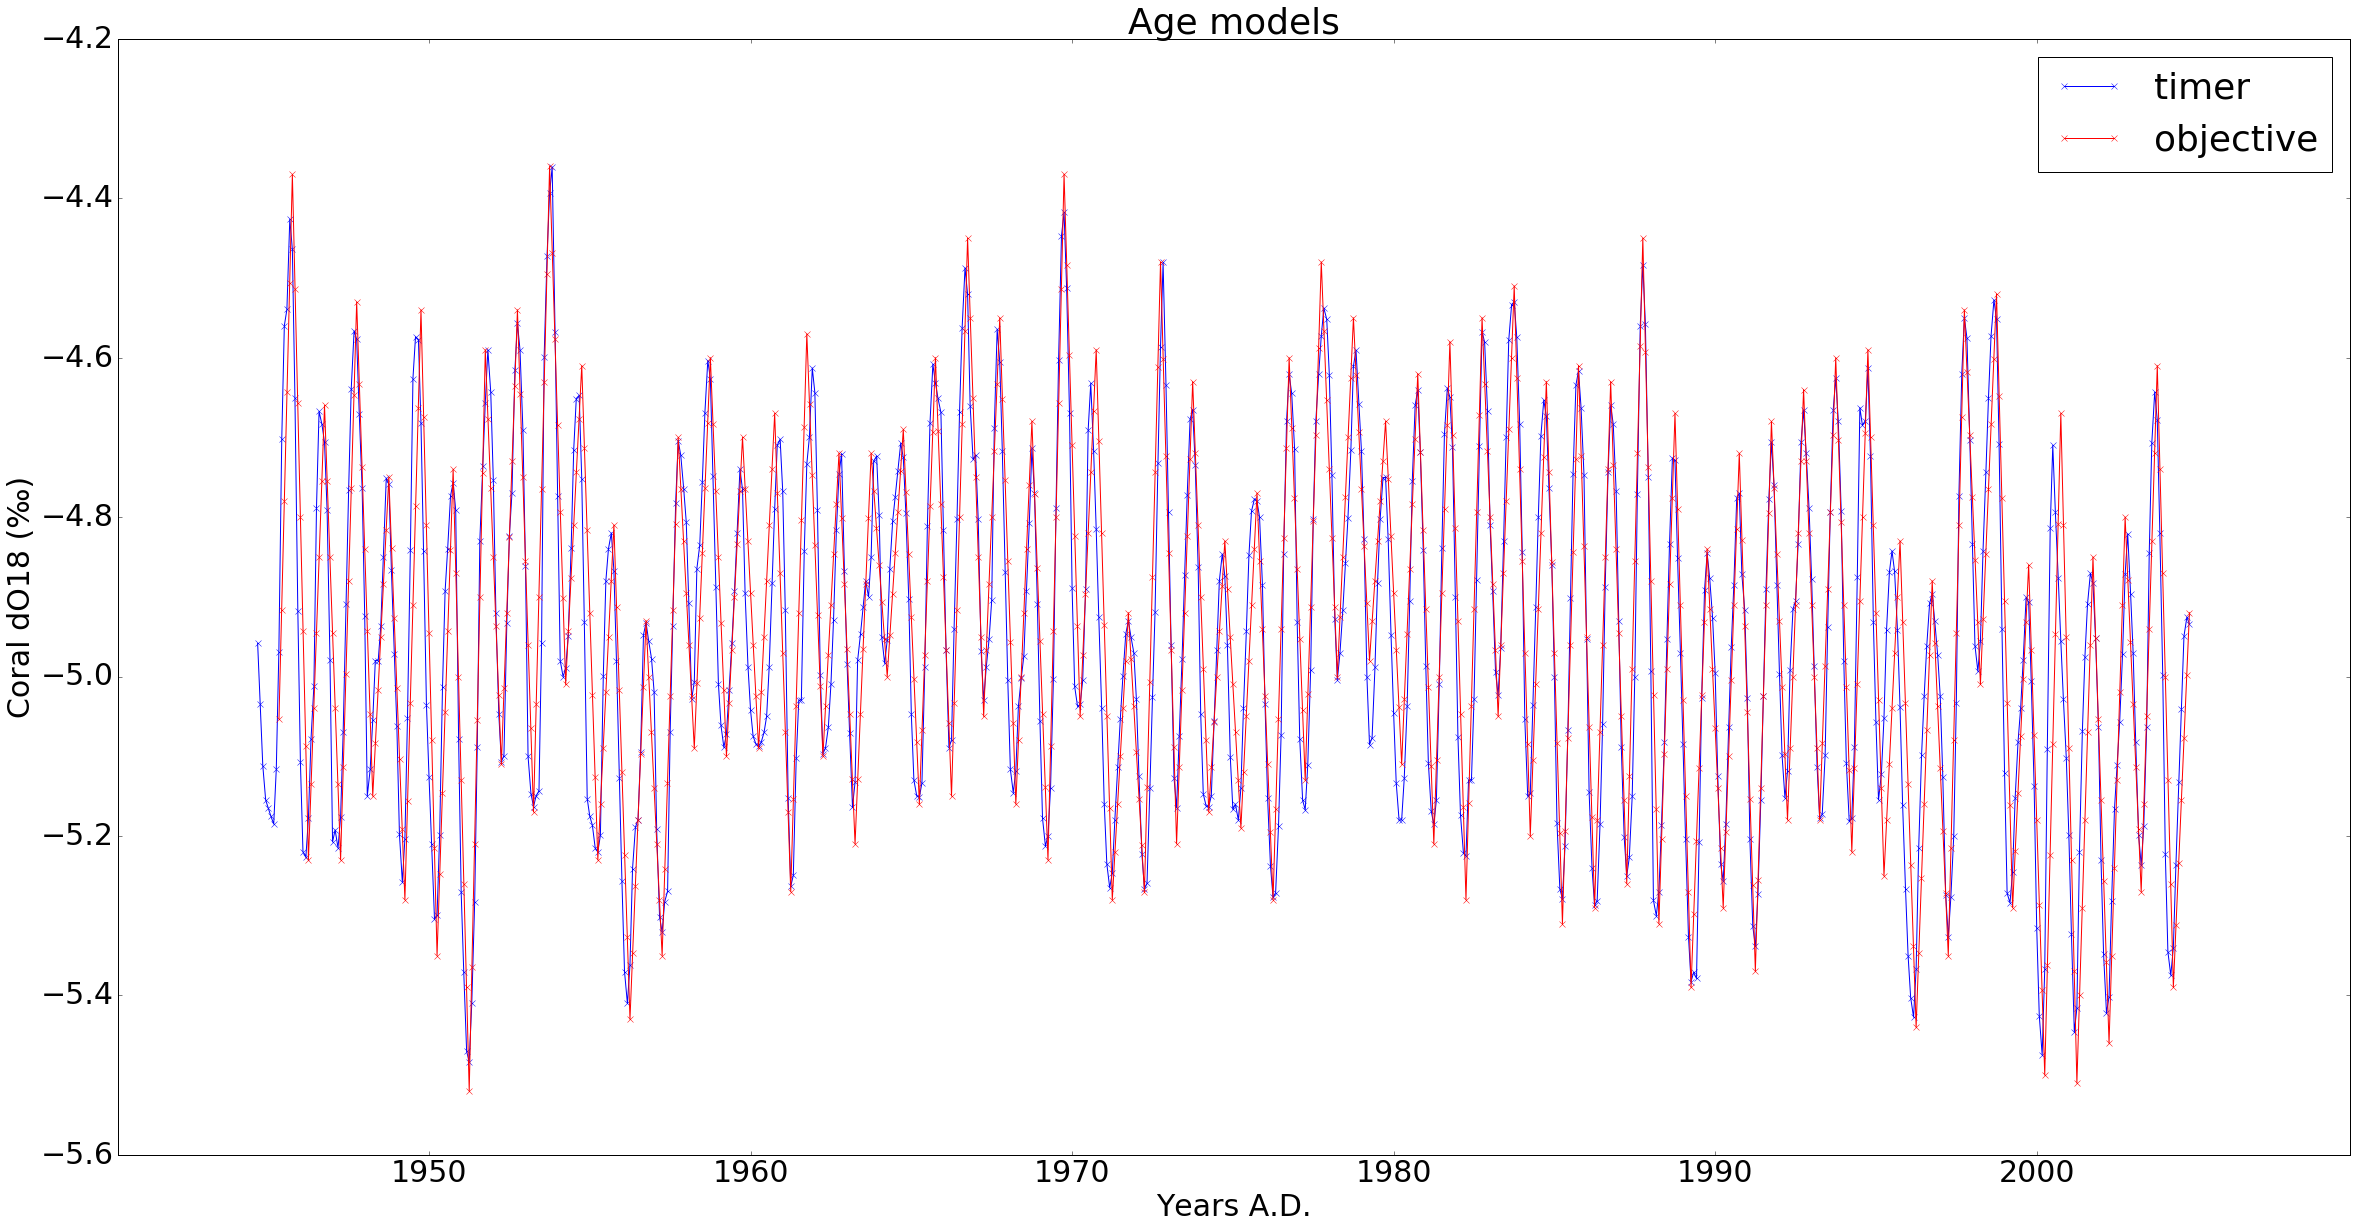

In [12]:
# dist between objective and timer age models deltaM = abs(len(estim.Dates)-len(timer.Dates))
maxplot= max(len(estim.Dates), len(timer.Dates))

plt.plot(timer.Dates[:],timer.dO18[:],color='b',marker='x',label="timer")
plt.plot(estim.Dates[:],estim.dO18[:],color='r',marker='x',label="objective")

plt.xlim(estim.Dates[len(dates)-1]-5,estim.Dates[0]+5)

plt.title("Age models")
plt.xlabel('Years A.D.')
plt.ylabel('Coral dO18 ('+u"\u2030"+')')
plt.legend()
plt.savefig("figure.png")